# Histopathologic Cancer Detection

We are working on the [Kaggle competition](https://www.kaggle.com/c/histopathologic-cancer-detection)
for Histopathologic Cancer Detection.

The data provided is CSV of image UUIDs and a boolean label for whether or not
the center patch of the image shows cancer. The images provided are 96x96 RGB
graphics in a TIF format. The challenge describes that we must detect cancer
in the center 32x32 portion, and that the rest of the image is provided
as padding.

The challenge confusingly states that the area outside of the center should
not be used for classification, but is provided as padding. This is unclear,
as those margins will still be factored in to the ultimate decision by being
included in the convolution kernels (they'll have an expanded receptive field).
We will proceed using the entire image for training.

## Exploratory Data Analysis and Data Loading

We perform some basic EDA on the data prodivded to us. The training data
provided as a CSV with the UUID for each image, and a label repsenting the presence
of metastatic cancer.

We first load the data into pandas, and shuffle the data right away to guarantee
that the data is randomized before we do anything else with it.

We have verified that there are only 2 labels: a 1 or 0 to indicate the presence.
We have also verified that there are no duplicates in the image UUIDs. So the CSV data
is presumed clean and ready to go.

We do have an imbalance between negative and positive labels (130k negative, 90k positive). 
We're choosing to not do anything about this to preserve the diversity of our data. 
This will likely skew our model towards false negatives, which would be an awful
situation for the real-world application of cancer detection, but it's fine
for this toy model.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
labels: [0 1]
label
0    130908
1     89117
Name: count, dtype: int64
unique ids:  220025


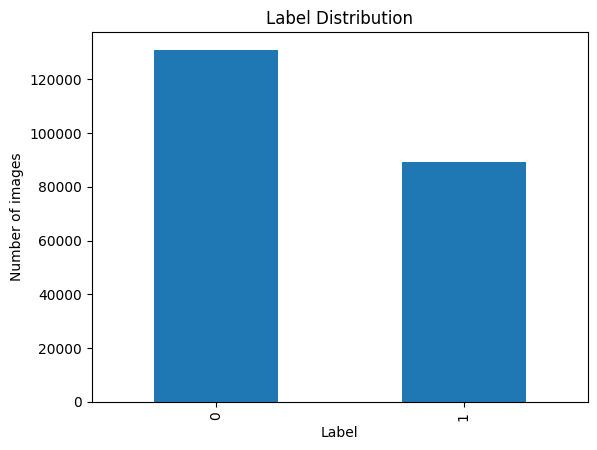

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

base_path = "./histopathologic-cancer-detection/"

df = pd.read_csv(base_path + 'train_labels.csv')
df = df.sample(frac=1, random_state=9222).reset_index(drop=True)
df.info()

print("labels:", df.label.unique())
print(df.label.value_counts())
print("unique ids: ", len(df.id.unique()))

df.head()

df.label.value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.show()

Let's define our pipeline for the data. Because there are so many images and they
are relatively large, we will define a PyTorch `Dataset` that defines the rules
for our dataset. We will also be provide a transformation pipeline we can use
for training to make our data more diverse and further avoid overfitting as we
start using more epochs. This should offer us a reasonable guarantee that the
model will never see exactly the same image twice.

We also print out a sample of our data images to make sure everything looks good.

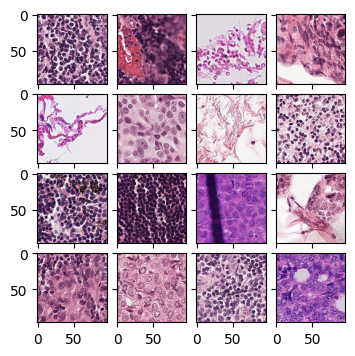

labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ImgDataset(Dataset):
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]

  alter_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomChoice([
      transforms.ColorJitter(hue=0.5),
      transforms.ColorJitter(brightness=0.5),
      transforms.ColorJitter(contrast=0.5),
      transforms.ColorJitter(saturation=0.5),
      transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
      transforms.RandomAutocontrast(1.0),
      transforms.RandomAdjustSharpness(1.0),
      transforms.RandomEqualize(1.0),
    ]),
    transforms.RandomChoice([
      transforms.RandomRotation(180, interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.RandomRotation(0),
    ]),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std),
  ])

  transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std),
  ])

  def __init__(self, df: pd.DataFrame, folder, alter=False):
    super().__init__()

    self.ids = df.id.to_list()
    self.labels = df.label.to_list()
    self.folder = folder
    self.alter = alter

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, idx):
    uuid = self.ids[idx]
    img = Image.open(f'{base_path}{self.folder}/{uuid}.tif')
    img = transforms.functional.pil_to_tensor(img)
    img = ImgDataset.alter_transform(img) if self.alter else ImgDataset.transform(img)
    return (img, self.labels[idx])

  def get_rgb(self, idx):
    img: torch.Tensor = self[idx][0]
    img = img.transpose(0, 2).cpu().numpy()
    img = img * np.array(ImgDataset.std) + np.array(ImgDataset.mean)
    img *= 255
    return img.astype(np.uint8)

  def show(self, offs=0):
    fig = plt.figure(figsize=(4., 4.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
    for i in range(16):
      grid[i].imshow(self.get_rgb(i+offs))
    plt.show()
    print("labels:", self.labels[offs:offs+16])

ds = ImgDataset(df, folder='train', alter=False)
ds.show()


Now we also want to test our "altered" dataset that will produce variants
of the images for training. The first batch of images shown here should have 
the same base images as the batch we show above. Notice how there are some variations
to the image color, as well as other spatial transformations. We use rotations and reflections
here to make our model more rotation and reflection invariant. The combination of 
alterations is almost limitless, giving us something close to an infinite dataset
(within reasonable limits, of course).

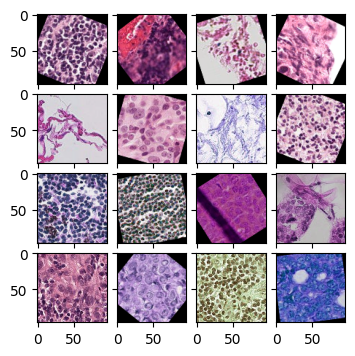

labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


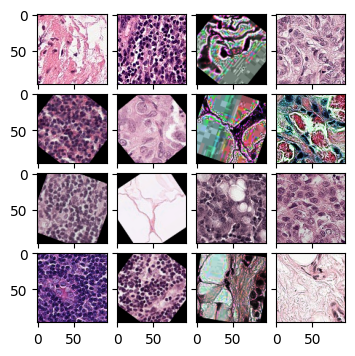

labels: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]


In [3]:
ds = ImgDataset(df, folder='train', alter=True)
ds.show()
ds.show(230)

### Data Loading, Image EDA, and Preprocessing

Now that we have our data loaded and processed, it's time to split out a validation and a training set.
Since our data has already been shuffled by Pandas after we loaded it, we can just split the DataFrames
where we want.

We produce our test dataset for a given split point. We also produce our full training set,
as well as a smaller training set we will use for hyperparamter selection.

test size: 33003


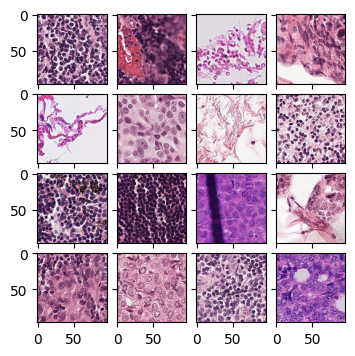

labels: [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
train size: 187022


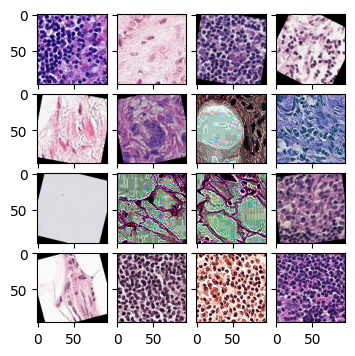

labels: [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
small train size: 18703


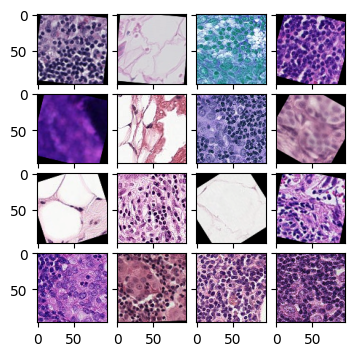

labels: [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
full train size: 220025


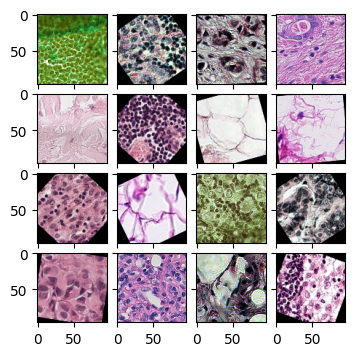

labels: [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]


In [19]:
from torch.utils.data import Dataset, DataLoader

test_split_pct = 0.15
split_idx = int(len(df) * test_split_pct)

test_ds = ImgDataset(df[:split_idx], folder='train')
train_ds = ImgDataset(df[split_idx:], folder='train', alter=True)
small_train_ds = ImgDataset(df[split_idx::10], folder='train', alter=True)
full_train_ds = ImgDataset(df, folder='train', alter=True)

print("test size:", len(test_ds))
test_ds.show()

print("train size:", len(train_ds))
train_ds.show()

print("small train size:", len(small_train_ds))
small_train_ds.show()

print("full train size:", len(full_train_ds))
full_train_ds.show(300)


## Modeling

Now that our data is ready to start training, we need to define our model.

The general form of our architecture will be that of a convolutional model.
The hyperparamters available for the model allow you to customize the
depth and width of the convolution stack, as well as the depth and width
of the classifier. We also offer an option called `res_blocks` that will
switch the model from normal convolutions to `ResNeXt` blocks, and specifies
the number of blocks per layer. These blocks
are the standard block of the ResNeXt model, and offer a grouped residual
convolution. These grouped residuals are extremely efficient as far
as FLOPS and parameters. They're an easy way to add more non-linearities
to your model without increasing the strict depth, which could harm the gradient
strength.

Between the convolution network and the classifier network, we use
a global average pooling to reduce the space down to a single patch,
which we can then flatten and feed into the classifier net. 

The classifier uses linear layers with `GELU` activation and a configurable
dropout. GELU is a good choice on these layers because we are not using batch normalization,
and GELU offers a lot of self-regularizing properties that should do the trick.

The classifier net then ends in a linear layer with an output of 2. We use
these 2 outputs to specify "detected" and "not detected". We do not use `softmax`
here because PyTorch offers an optimized `CrossEntropyLoss` that works better
without the activation normalization.

In our hyperparamter selection, we will test these major architectures:
* Standard Convolutional
* ResNeXt

In [5]:
import torch
from torch import nn
from torch.nn.functional import relu
import gc

# TODO: use https://captum.ai/docs/extension/integrated_gradients ?

class ResNeXtBlock(nn.Module):
  def __init__(self, num_channels, bot_mul=4, group_size=4, stride=1):
    super().__init__()
    bot_channels = int(round(num_channels * bot_mul))
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                               stride=stride, padding=1,
                               groups=bot_channels//group_size)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.bn2 = nn.LazyBatchNorm2d()
    self.bn3 = nn.LazyBatchNorm2d()
    if stride != 1:
      self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                 stride=stride)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None

  def forward(self, X):
    Y = relu(self.bn1(self.conv1(X)))
    Y = relu(self.bn2(self.conv2(Y)))
    Y = self.bn3(self.conv3(Y))
    if self.conv4:
      X = self.bn4(self.conv4(X))
    return relu(Y + X)

class Model(nn.Module):
  def __init__(self,
               conv_arch=[64, 96, 128],
               class_arch=[128, 128],
               class_dropout=0.3,
               res_blocks=2,
    ):
    super().__init__()

    self.conv_net = nn.Sequential(
      nn.LazyConv2d(conv_arch[0], 7, 2, 3),
      nn.LazyBatchNorm2d(),
      nn.ReLU(),
      nn.MaxPool2d(3, 2, 1),
    )

    for i, x in enumerate(conv_arch):
      if res_blocks: self.conv_net.extend([
        ResNeXtBlock(x, stride = 1 if i == 0 or n != 0 else 2)
        for n in range(res_blocks)
      ])
      else: self.conv_net.extend([
        nn.LazyConv2d(x, 3, 2, 1)
      ])

    self.conv_net.extend([
      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
    ])

    self.classifier = nn.Sequential()
    for x in class_arch:
      self.classifier.extend([
        nn.LazyLinear(x),
        nn.GELU(),
        nn.Dropout(class_dropout),
      ])
    self.classifier.append(nn.LazyLinear(2))

  def forward(self, x: torch.Tensor):
    x = self.conv_net(x)
    x = self.classifier(x)
    return x

model = Model().to(device)

x = train_ds[0][0].to(device).unsqueeze(0).float()
print(model(x).shape)
model = None

gc.collect()
torch.cuda.empty_cache()


torch.Size([1, 2])


### Training

We define our training loop below. We're using the `Adam` optimizer which offers
good general performance and avoidance of local minima. Given our model is using
batch normalization, our gradient surface should have less extreme features, but it's
usually a good idea to use an optimizer with some momentum anyways, and Adam has 
pretty good behavior for most applications.

Our loss function is cross-entropy.

We also define a learning rate annealing pattern. Instead of defining a learning rate
schedule, which is often burdened with more hyperparamters, we instead linearly anneal to 0.
This can often be wasteful, as the end of the training session may have very low learning 
rates, but it is a good way to guarantee that we visit all learning rates and settle
into whatever minimum we landed on.

The training loop offers an option to train on the full dataset, which we will explain later.

We record the train and test validation at each epoch and return that data. We will
use that for graphing after our training is complete.

In [6]:
import multiprocessing as mp
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt 

# enable tensorfloat32
torch.set_float32_matmul_precision('high')

def test_accuracy(model, dl):
  acc = 0
  count = 0
  for x, y in dl:
    y_pred = model(x.to(device))
    y_pred = y_pred.argmax(dim=-1).cpu().numpy()
    acc += accuracy_score(y, y_pred) * len(y)
    count += len(y)
  return acc / count

def train(model, epochs, ds, minibatch_size=512, initial_lr=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), initial_lr)
  loss_fn = nn.CrossEntropyLoss()
  accs = []
  test_accs = []

  dl = DataLoader(ds, minibatch_size, shuffle=True,
                  num_workers=10,
                  prefetch_factor=1,
                  pin_memory=torch.cuda.is_available())

  test_dl = DataLoader(test_ds, 512,
                       num_workers=6,
                       pin_memory=torch.cuda.is_available())

  for epoch in range(epochs):
    anneal_frac = 1.0 - epoch / epochs
    lr = initial_lr * anneal_frac
    optimizer.param_groups[0]["lr"] = lr

    model.train()

    minibatches = 0
    total_loss = 0
    total_acc = 0
    for x, y in dl:
      optimizer.zero_grad()
      y_pred = model(x.to(device))
      loss = loss_fn(y_pred, y.to(device))
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      total_loss += loss.item()
      y_pred = y_pred.argmax(dim=-1)
      total_acc += accuracy_score(y, y_pred.cpu().numpy())
      minibatches += 1

      x = None
      y = None
      loss = None
      y_pred = None
      gc.collect()

    model.eval()
    epoch_loss = total_loss / minibatches
    with torch.no_grad():
      test_acc = test_accuracy(model, test_dl)
    acc = total_acc / minibatches

    accs.append(acc)
    test_accs.append(test_acc)

    print("epoch:", epoch+1, "loss:", epoch_loss, "lr:", lr)
    print("acc:", acc, "test acc:", test_acc)

  plt.plot(np.arange(len(accs)), accs, label='train')
  plt.plot(np.arange(len(test_accs)), test_accs, label='test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

### Hyperparameter Search

We're going to use our smaller training set and a lower number of epochs to find a
good hyperparameter search. We are going to simply try a few different configurations
and see which has the highest test accuracy in the end. This is a bit of a naive approach,
as something like Optuna could be used to perform a full HP search. But given
my time constraints, I've chosen to just test a sampling of HPs and provide with those.

epoch: 1 loss: 0.6524117250700254 lr: 0.001
acc: 0.6088040805450284 test acc: 0.7499318243796018
epoch: 2 loss: 0.5670367173246436 lr: 0.0008
acc: 0.7129184794804029 test acc: 0.783443929339757
epoch: 3 loss: 0.5388522703905363 lr: 0.0006
acc: 0.7270005750099731 test acc: 0.7877162682180407
epoch: 4 loss: 0.5287133616370123 lr: 0.0004
acc: 0.7392651169966091 test acc: 0.7864739569130079
epoch: 5 loss: 0.5210523661729451 lr: 0.00019999999999999996
acc: 0.7441217307021043 test acc: 0.7923522104051147


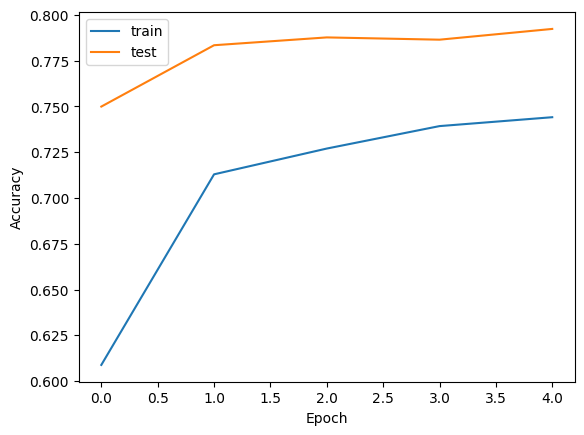

In [7]:
# Configuration A
model = Model(conv_arch=[16, 32, 64], class_arch=[64, 64], res_blocks=None).to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.5389732935944119 lr: 0.001
acc: 0.7286726229804528 test acc: 0.7948368330151805
epoch: 2 loss: 0.4710130933168772 lr: 0.0008
acc: 0.7800403753615239 test acc: 0.8040481168378633
epoch: 3 loss: 0.44067007544878367 lr: 0.0006
acc: 0.7976186951481001 test acc: 0.8231675908250765
epoch: 4 loss: 0.4238581802393939 lr: 0.0004
acc: 0.8088154171237658 test acc: 0.831591067478714
epoch: 5 loss: 0.4023870938533061 lr: 0.00019999999999999996
acc: 0.8171559835319637 test acc: 0.8468018058964336


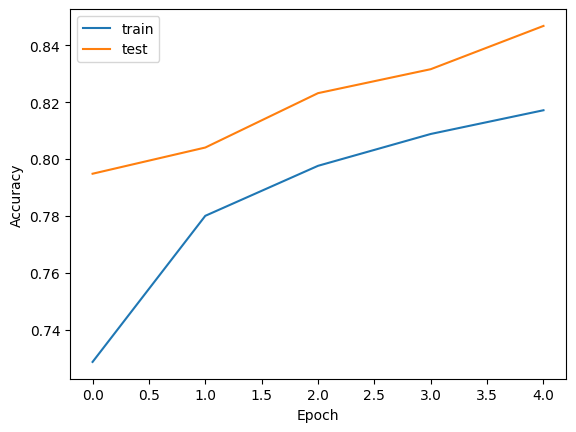

In [10]:
# Configuration B
model = Model().to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.5667760267451003 lr: 0.001
acc: 0.6982613739777601 test acc: 0.7691118989182801
epoch: 2 loss: 0.505364977024697 lr: 0.0008
acc: 0.7493065597885709 test acc: 0.7884737751113535
epoch: 3 loss: 0.47666978111138214 lr: 0.0006
acc: 0.7712722524184702 test acc: 0.8096536678483774
epoch: 4 loss: 0.46191420184599385 lr: 0.0004
acc: 0.7863454220479705 test acc: 0.8113807835651304
epoch: 5 loss: 0.44946624137259816 lr: 0.00019999999999999996
acc: 0.794163960431834 test acc: 0.8093506650910524


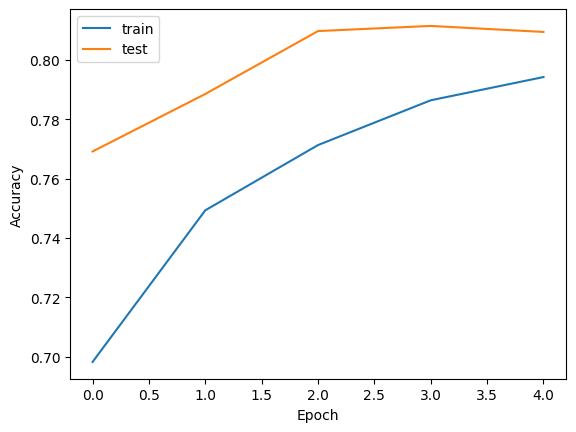

In [9]:
# Configuration C
model = Model(conv_arch=[16, 32, 64], class_arch=[64, 32], res_blocks=3).to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.56941898529594 lr: 0.001
acc: 0.6990529866236163 test acc: 0.7811714086598188
epoch: 2 loss: 0.5067816634435911 lr: 0.0008
acc: 0.7527085073426748 test acc: 0.8018361967093901
epoch: 3 loss: 0.4791123134058875 lr: 0.0006
acc: 0.7758939535130149 test acc: 0.8018664969851226
epoch: 4 loss: 0.4681359827518463 lr: 0.0004
acc: 0.7818407876857485 test acc: 0.8046844226282459
epoch: 5 loss: 0.4506942307626879 lr: 0.00019999999999999996
acc: 0.7894953157724145 test acc: 0.818198345604945


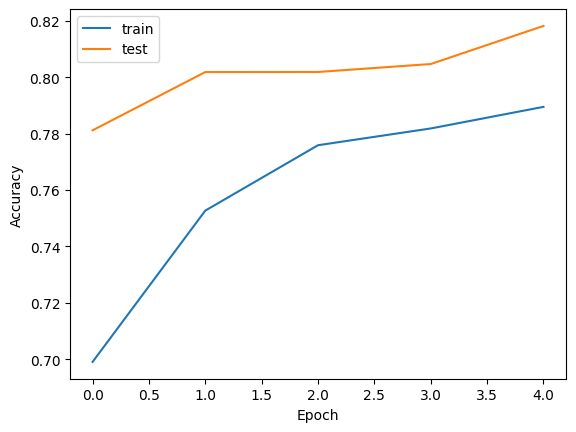

In [11]:
# Configuration D
model = Model(conv_arch=[16, 32, 64], class_arch=[64, 64], res_blocks=3, class_dropout=0.4).to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.5524428543206807 lr: 0.001
acc: 0.7180505214047073 test acc: 0.7826561221707118
epoch: 2 loss: 0.48799763821266795 lr: 0.0008
acc: 0.7709553346589209 test acc: 0.810108171984365
epoch: 3 loss: 0.4660684418033909 lr: 0.0006
acc: 0.7843691174453975 test acc: 0.8185013483622701
epoch: 4 loss: 0.45111638549211863 lr: 0.0004
acc: 0.792826750585918 test acc: 0.81813774505348
epoch: 5 loss: 0.43950596854493423 lr: 0.00019999999999999996
acc: 0.8001466353345965 test acc: 0.825106808471957


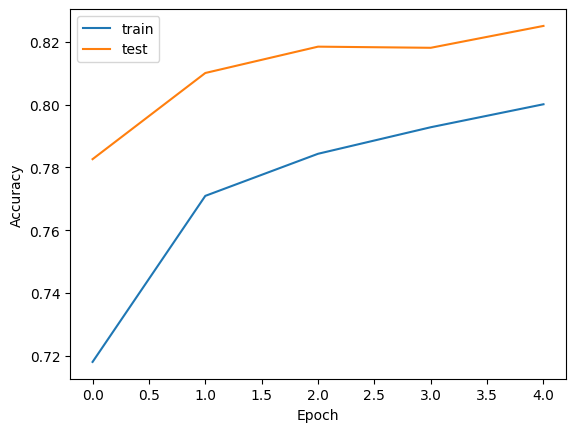

In [12]:
# Configuration E
model = Model(conv_arch=[32, 64, 128], class_arch=[64, 32], res_blocks=1, class_dropout=0.2).to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.542171747297854 lr: 0.001
acc: 0.7269244134586617 test acc: 0.7869284610489955
epoch: 2 loss: 0.47718257356334376 lr: 0.0008
acc: 0.7761871073102623 test acc: 0.7831712268581644
epoch: 3 loss: 0.44872673701595617 lr: 0.0006
acc: 0.7937888014859878 test acc: 0.8203496651819532
epoch: 4 loss: 0.43023743017299754 lr: 0.0004
acc: 0.8041939108157973 test acc: 0.8378026240038784
epoch: 5 loss: 0.41426841954927185 lr: 0.00019999999999999996
acc: 0.8137953307320235 test acc: 0.8432869739114626


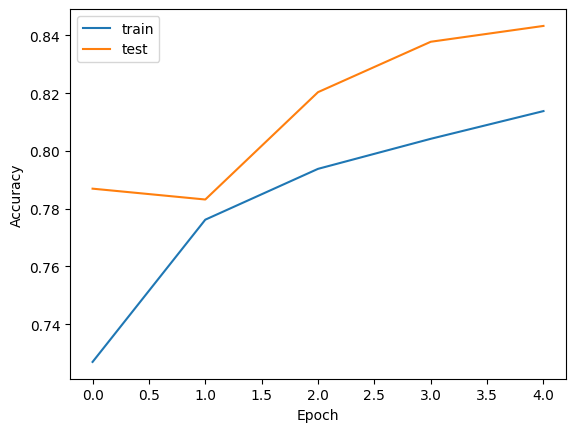

In [15]:
# Configuration F
model = Model(res_blocks=3).to(device)
train(model, 5, small_train_ds)

epoch: 1 loss: 0.5524383179239325 lr: 0.001
acc: 0.7113876517777002 test acc: 0.7964730479047359
epoch: 2 loss: 0.4821318935703587 lr: 0.0008
acc: 0.7748146410940461 test acc: 0.7731418355907039
epoch: 3 loss: 0.4576670334145829 lr: 0.0006
acc: 0.7864570347561584 test acc: 0.7940793261218677
epoch: 4 loss: 0.4369857077663009 lr: 0.0004
acc: 0.7999882738481101 test acc: 0.8261370178468624
epoch: 5 loss: 0.4175884844483556 lr: 0.00019999999999999996
acc: 0.8126044056048668 test acc: 0.839681241099294


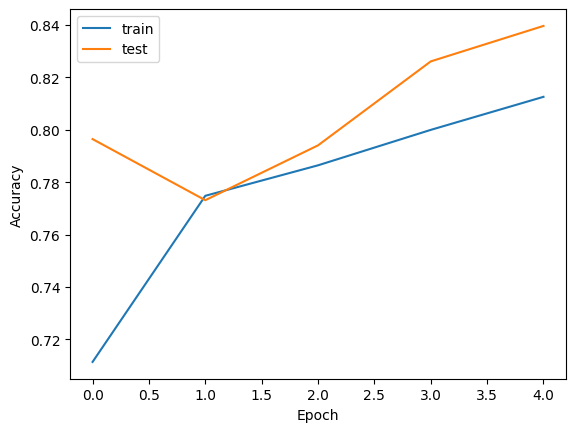

In [37]:
# Configuration G
model = Model(res_blocks=4).to(device)
train(model, 5, small_train_ds)

### Initial Training and Hyperparameter Search Results

We've observed the different hyperparameter options above on the small
training set, and our default configuration seems to be the most optimal,
using the ResNeXt blocks (stack of 2) with an increasing number of features per layer.

| Configuration | Test Accuracy | Description |
| -------- | ------- | ----- |
| A             | 79%           | Small convolutions and classifier, no residuals |
| B             | 84%           | Default config- conv blocks starting at 64, w/ residuals |
| C             | 80%           | Same small conv as A, but with res blocks |
| D             | 81%           | Small conv blocks, but with high residual and higher dropout |
| E             | 82%           | Small conv blocks, but with low residual and lower dropout |
| F             | 84%           | Same as B, but with 3 residual blocks |
| G             | 84%           | Same as B, but with 4 residual blocks |

The configurations with smaller convolutions likely didn't due to the total
complexity of training rotation or reflection invariant models. Convolutions do
not have any inherent ability to handle that, so kernels likely have to be learned
for all rotational variants of any important feature in the hierarchy. The residual
networks are likely helpful because they are a powerful and cheap way to add additional
non-linearities to the network in a way that does not cause the gradient to suffer.

We will chosse `Configuration G` as it should do better having more nonlinearities
to it, and likely just had slower training during our HP search. But all variants
of the base model (B, F, G) scored high, at 84% test accuracy.

We've finished our initial training of the model below and graphed the test and training
accuracy below. As was hoped, we have overfitting characteristics that do not
cause the test set to regress in accuracy, and instead they both improve with the margin
only getting slightly larger as time goes on.

This behavior is important as we plan to train the model on the full dataset.
Once we've verified that extensive training will not cause the model to regress
in test accuracy over time, we can be confident that training for a lesser number
of epochs on the full dataset will not cause overfitting.

Our final test accuracy is 96%.

epoch: 1 loss: 0.4373837759097417 lr: 0.001
acc: 0.7972925926460401 test acc: 0.8334393842983971
epoch: 2 loss: 0.3377998342605236 lr: 0.0009714285714285714
acc: 0.854117887396098 test acc: 0.8913129109474897
epoch: 3 loss: 0.2880908036655416 lr: 0.0009428571428571429
acc: 0.8807340821740554 test acc: 0.9116140956882708
epoch: 4 loss: 0.2587983692930044 lr: 0.0009142857142857143
acc: 0.8954009340365966 test acc: 0.8914644123261521
epoch: 5 loss: 0.2408691609247786 lr: 0.0008857142857142857
acc: 0.9043582061013622 test acc: 0.9286428506499409
epoch: 6 loss: 0.22810216162536964 lr: 0.0008571428571428572
acc: 0.9096349356384207 test acc: 0.9228857982607642
epoch: 7 loss: 0.21696664808226412 lr: 0.0008285714285714285
acc: 0.9152670999528593 test acc: 0.9344605035905826
epoch: 8 loss: 0.21125200264603713 lr: 0.0008
acc: 0.9180237676056338 test acc: 0.9332181922855498
epoch: 9 loss: 0.20269419395369911 lr: 0.0007714285714285715
acc: 0.9220818421457708 test acc: 0.9381268369542163
epoch: 10 l

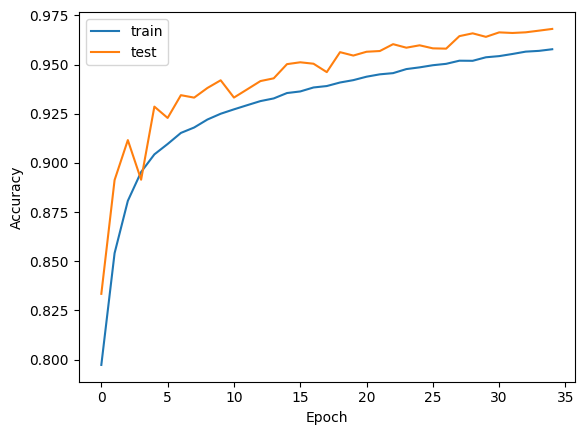

In [38]:
model = Model(res_blocks=4).to(device)
train(model, 35, train_ds)

### Fine Tuning

Now that we have a model trained on our training set, we go ahead
and do a small fine tuning pass using the entire training dataset we've been
given. We observed previously that overfitting is mostly avoided given
that our test set accuracy does not regress at any point. This is due
to our choice of regularization in the model (dropout and GELU), and
the alterations we make to our training data.

This small extra pass should give us even more diversity in our model, and
it will hopefully perform well on the Kaggle test set. Although now
that we've "polluted" our model with the full training data, our test
accuracy is less meaninful, but is still calculated and graphed below.


epoch: 1 loss: 0.1603055580237577 lr: 0.001
acc: 0.9402570255150823 test acc: 0.9529133715116808
epoch: 2 loss: 0.1535845824105795 lr: 0.0008
acc: 0.9427937868191352 test acc: 0.952095264066903
epoch: 3 loss: 0.14361721999769986 lr: 0.0006
acc: 0.9473635282369995 test acc: 0.9617610520255734
epoch: 4 loss: 0.13326145096920258 lr: 0.0004
acc: 0.9513960066659983 test acc: 0.9623973578159561
epoch: 5 loss: 0.12606041769302168 lr: 0.00019999999999999996
acc: 0.9535515646204737 test acc: 0.9712450383298488


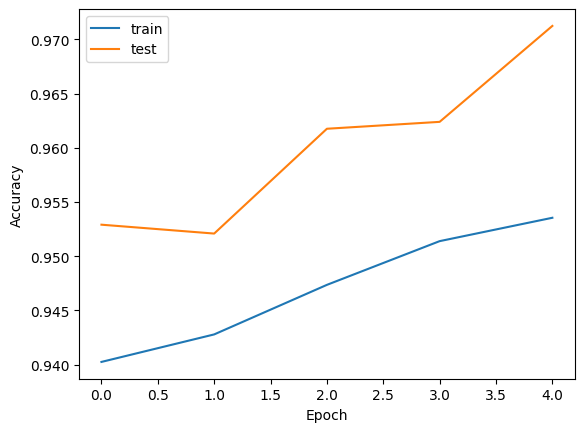

In [39]:
train(model, 5, full_train_ds)

We also present the confusion matrix for our test set at this point.
We appear to have a somewhat equal number of false negatives and false positives,
with slightly more false positives. This is a bit surprising considering the
distribution of our labeled data is negative heavy.

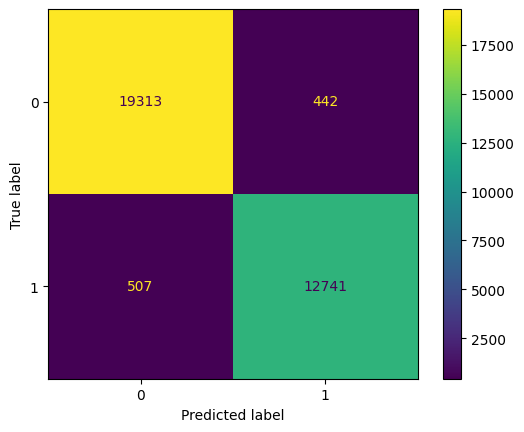

ROC AUC: 0.9696779949765056


In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

model.eval()

test_dl = DataLoader(test_ds, 512,
                      num_workers=6,
                      pin_memory=torch.cuda.is_available())

y_pred = []
y_true = []
for x, y in test_dl:
  y_pred_b: torch.Tensor = model(x.to(device))
  y_pred_b = y_pred_b.argmax(dim=-1).cpu().tolist()
  y_pred.extend(y_pred_b)
  y_true.extend(y.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

auc = roc_auc_score(y_true, y_pred)
print('ROC AUC:', auc)

## Producing the Kaggle Submission Data

We're now ready to use the model to label our test data provided by Kaggle.
This data has been untouched up until now. Let's start by loading it and 
producing our label column in the dataframe. We'll use a slightly different 
loop to load and label the data, as we are running out of RAM at this point
and I am stubbornly refusing to save and load the model or data, as it makes the notebook
look less clean. Sorry/not-sorry.

We will load the `sample_submissions.csv` file as it seems to have all the IDs
we need.

In [41]:
df = pd.read_csv(base_path + 'sample_submission.csv')

df.info()
df.head()

submit_ds = ImgDataset(df, folder='test')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [42]:
submit_dl = DataLoader(submit_ds, 512,
                      num_workers=6,
                      pin_memory=torch.cuda.is_available())

y_pred = []
for x, _ in submit_dl:
  y_pred_b: torch.Tensor = model(x.to(device))
  y_pred_b = y_pred_b.argmax(dim=-1).cpu().tolist()
  y_pred.extend(y_pred_b)

df['label'] = y_pred

In [43]:
df.sample(n=15)

,id,label
23907,1740efb831a8559fd2a77d556326a284138a6eb9,0
53879,b9db8350383d232a474d841db5b76ed19eff8b23,0
5663,f79ef320bc04c2441c93bff62eea8578ba45fcf5,1
19396,d95f205d8cf75b74b0fc2391ab508ab7b028c2a6,0
26386,0641beb7a9e9d0fd2690506fe7ea3b71e8ecf798,1
20311,8fdcebbad6a09f6d7300d183ffb213c7982fb14c,0
42685,670a0d22c2d5f6345889c52f68f6c33c8831b9d2,1
4341,84c4c684212717d74bf8fa725fbc7b6183635530,0
53070,5c0d81e853246a1824f32f6321c7edfe79ae8ae5,1
26714,cab27c5c6547f41386ea7cc60660e97cb0d7affe,1


In [44]:
df.to_csv(base_path + 'submission.csv', index=False)

### Submission Results

Our submission scores 90% accuracy on the kaggle provided dataset.

## Conclusion, Analysis, and Considerations

We've proven that using a ResNeXt style convolutional model is the right
type of model to use for this problem. The model we've produced is capable
of identifying cancer cells to 90% accuracy based on slide imaging of tissue
samples. We've learned that the residual connections used in ResNeXt architectures
is a great way to increase the capability of the model without adding too many
additional features, parameters or FLOPS. We've also learned that overfitting is real concern,
and that training image transformation, as well as regularization, are important
to producing an image model that is capable of generalizing the problem.

To continue this work, it would be wise to consider a full hyperparamter search
using a framework such as Optuna. It would also be good to better understand
the imaging and dyes used for these tissue samples to better augment our
training transformation. Further consideration should also be given to training time:
the models here were not trained until convergence.

Analysizing the model and the outcomes is difficult without having the ground truth
available for the kaggle test set, but we have used `IntegratedGraphics` below
to showcase some of what our model has learned. IG uses a form of gradient ascent
to produce data that is similar to input that highlights what parts of the image
were important to arriving at that particular label, and can offer some insights
into what parts of the image are used for classification. 

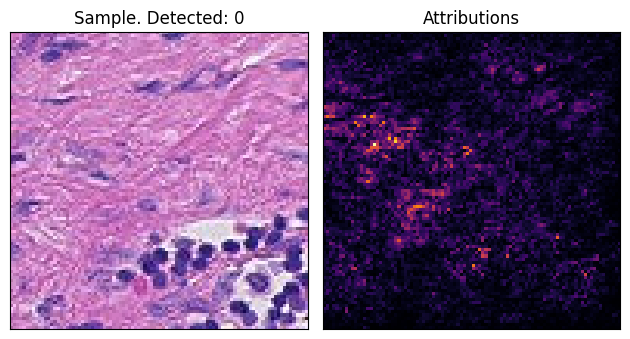

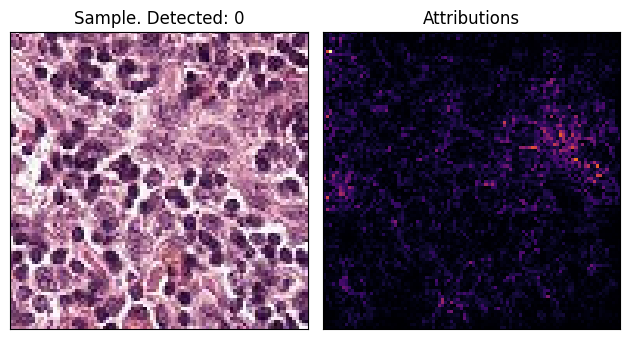

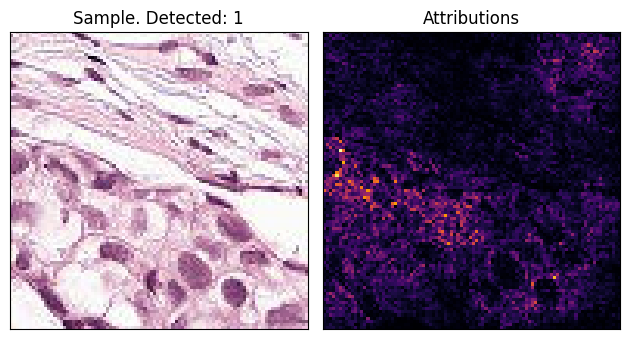

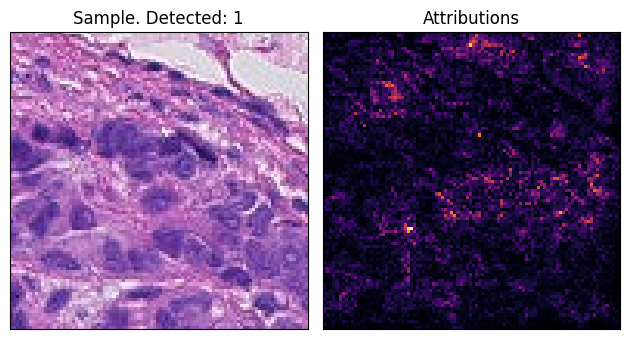

In [74]:
from captum.attr import IntegratedGradients

def show_attr(test_idx):
  test_idx += 10
  input, label = test_ds[test_idx]
  input = input.unsqueeze(0).to(device)

  ig = IntegratedGradients(model)
  attributions, approximation_error = ig.attribute(input,
                                                  target=label,
                                                  method='gausslegendre',
                                                  return_convergence_delta=True)

  attributions = attributions.squeeze().transpose(0, 2).cpu().detach().numpy()

  _, ax = plt.subplots(nrows=1, ncols=2)
  orig = ax[0]
  mod = ax[1]
  orig.imshow(test_ds.get_rgb(test_idx))
  orig.set_title(f"Sample. Detected: {label}")
  orig.set_xticks([])
  orig.set_yticks([])
  mod.imshow(np.mean(np.abs(attributions), axis=2), cmap="inferno")
  mod.set_title("Attributions")
  mod.set_xticks([])
  mod.set_yticks([])
  plt.tight_layout()
  plt.show()

show_attr(10)
show_attr(200)
show_attr(35)
show_attr(77)